Found 3456 images belonging to 5 classes.
Found 860 images belonging to 5 classes.
Epoch 1/10, Train Loss: 1.608914008075246, Val Loss: 1.6083422287976739, Val Accuracy: 0.09375
Epoch 2/10, Train Loss: 1.608463141747882, Val Loss: 1.6066516044041013, Val Accuracy: 0.3125
Epoch 3/10, Train Loss: 1.6080126539150972, Val Loss: 1.6049753039155676, Val Accuracy: 0.46875
Epoch 4/10, Train Loss: 1.607563275960413, Val Loss: 1.6033154902937503, Val Accuracy: 0.53125
Epoch 5/10, Train Loss: 1.6071160371347757, Val Loss: 1.601673629403365, Val Accuracy: 0.71875
Epoch 6/10, Train Loss: 1.6066720393132368, Val Loss: 1.600050217305031, Val Accuracy: 0.75
Epoch 7/10, Train Loss: 1.606232214500407, Val Loss: 1.5984448189565945, Val Accuracy: 0.8125
Epoch 8/10, Train Loss: 1.6057971603241192, Val Loss: 1.596856319888833, Val Accuracy: 0.84375
Epoch 9/10, Train Loss: 1.6053670944856395, Val Loss: 1.5952832307013591, Val Accuracy: 0.875
Epoch 10/10, Train Loss: 1.6049419061597008, Val Loss: 1.5937239358

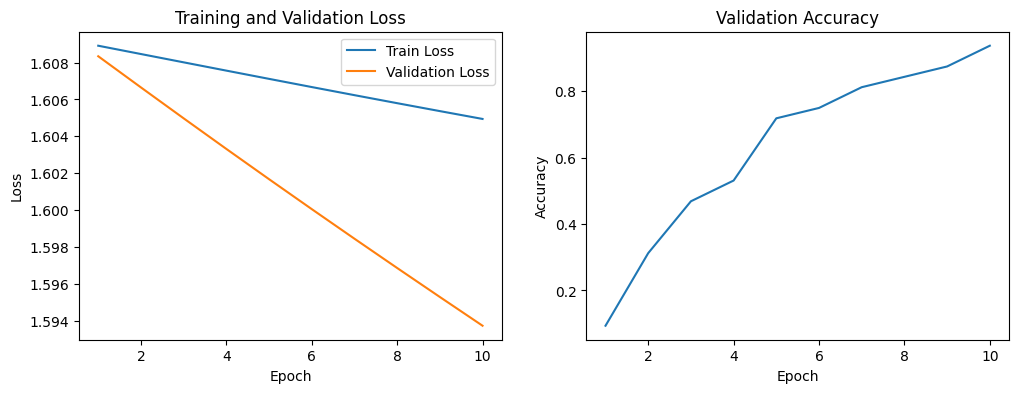

Test Accuracy: 0.9375
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        32
           2       0.00      0.00      0.00         0

    accuracy                           0.94        32
   macro avg       0.50      0.47      0.48        32
weighted avg       1.00      0.94      0.97        32



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1146:

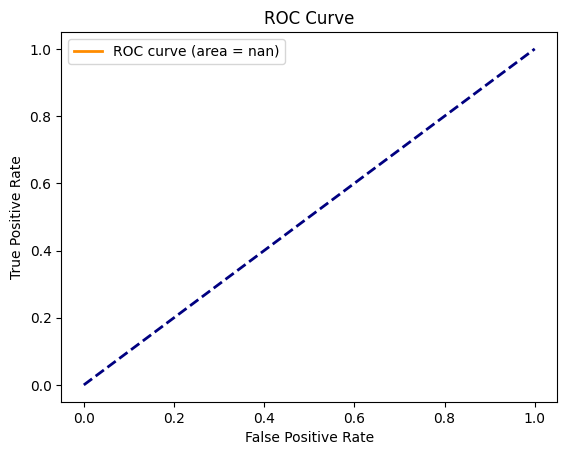

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 1: Load the Flower Recognition dataset

# Directory containing the images
data_dir = "/content/drive/MyDrive/flowers"

# Preprocess the data using ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load the training data
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  # Resize images to (224, 224)
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Load the validation data
val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

# Step 2: Initialize the weights and biases of the MLP using random values
def initialize_parameters(input_size, hidden_size1, hidden_size2, output_size):
    np.random.seed(42)
    W1 = np.random.randn(input_size, hidden_size1) * 0.01
    b1 = np.zeros((1, hidden_size1))
    W2 = np.random.randn(hidden_size1, hidden_size2) * 0.01
    b2 = np.zeros((1, hidden_size2))
    W3 = np.random.randn(hidden_size2, output_size) * 0.01
    b3 = np.zeros((1, output_size))

    parameters = {"W1": W1, "b1": b1,
                  "W2": W2, "b2": b2,
                  "W3": W3, "b3": b3}

    return parameters

# Step 3: Implement the forward pass of the MLP
def forward_pass(X, parameters):
    W1, b1, W2, b2, W3, b3 = parameters['W1'], parameters['b1'], parameters['W2'], parameters['b2'], parameters['W3'], parameters['b3']

    # Forward propagation
    Z1 = np.dot(X, W1) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(A1, W2) + b2
    A2 = np.tanh(Z2)
    Z3 = np.dot(A2, W3) + b3
    A3 = softmax(Z3)

    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)

    return A3, cache

# Step 4: Implement the backward pass of the MLP
def backward_pass(X, Y, cache):
    m = X.shape[0]
    Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3 = cache

    # Backward propagation
    dZ3 = A3 - Y
    dW3 = 1/m * np.dot(A2.T, dZ3)
    db3 = 1/m * np.sum(dZ3, axis=0, keepdims=True)
    dA2 = np.dot(dZ3, W3.T)
    dZ2 = dA2 * (1 - np.power(A2, 2))
    dW2 = 1/m * np.dot(A1.T, dZ2)
    db2 = 1/m * np.sum(dZ2, axis=0, keepdims=True)
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * (1 - np.power(A1, 2))
    dW1 = 1/m * np.dot(X.T, dZ1)
    db1 = 1/m * np.sum(dZ1, axis=0, keepdims=True)

    gradients = {"dW1": dW1, "db1": db1,
                 "dW2": dW2, "db2": db2,
                 "dW3": dW3, "db3": db3}

    return gradients

# Step 5: Update the weights and biases using stochastic gradient descent optimization algorithm
def update_parameters(parameters, gradients, learning_rate):
    parameters['W1'] -= learning_rate * gradients['dW1']
    parameters['b1'] -= learning_rate * gradients['db1']
    parameters['W2'] -= learning_rate * gradients['dW2']
    parameters['b2'] -= learning_rate * gradients['db2']
    parameters['W3'] -= learning_rate * gradients['dW3']
    parameters['b3'] -= learning_rate * gradients['db3']

    return parameters

# Step 6: Train the MLP for 10 epochs and monitor the accuracy on the validation set after each epoch
def train_mlp(X_train, Y_train, X_val, Y_val, parameters, learning_rate, num_epochs):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Forward propagation
        A3_train, cache = forward_pass(X_train, parameters)

        # Compute loss
        train_loss = compute_loss(Y_train, A3_train)
        train_losses.append(train_loss)

        # Backward propagation
        gradients = backward_pass(X_train, Y_train, cache)

        # Update parameters
        parameters = update_parameters(parameters, gradients, learning_rate)

        # Forward propagation for validation set
        A3_val, _ = forward_pass(X_val, parameters)

        # Compute validation loss
        val_loss = compute_loss(Y_val, A3_val)
        val_losses.append(val_loss)

        # Compute validation accuracy
        val_accuracy = compute_accuracy(Y_val, A3_val)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")

    return parameters, train_losses, val_losses, val_accuracies

# Step 7: Evaluate the final accuracy of the trained MLP on the test set, and calculate the classification report
def evaluate_mlp(X_test, Y_test, parameters):
    A3_test, _ = forward_pass(X_test, parameters)
    test_accuracy = compute_accuracy(Y_test, A3_test)
    print(f"Test Accuracy: {test_accuracy}")

    # Compute classification report
    predictions = np.argmax(A3_test, axis=1)
    true_labels = np.argmax(Y_test, axis=1)
    print(classification_report(true_labels, predictions))

# Step 8: Plot the ROC curve for the classifier, and calculate the area under the curve (AUC)
def plot_roc_curve_mlp(X_test, Y_test, parameters):
    A3_test, _ = forward_pass(X_test, parameters)
    fpr, tpr, thresholds = roc_curve(Y_test[:, 1], A3_test[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Step 9: Define additional functions
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def compute_loss(Y, A):
    m = Y.shape[0]
    return -1/m * np.sum(Y * np.log(A))

def compute_accuracy(Y, A):
    predictions = np.argmax(A, axis=1)
    true_labels = np.argmax(Y, axis=1)
    return accuracy_score(true_labels, predictions)

# Step 10: Define main function
def main():
    # Define parameters
    input_size = 224 * 224 * 3
    hidden_size1 = 128
    hidden_size2 = 64
    output_size = 5  # 5 classes: daisy, dandelion, rose, sunflower, tulip
    learning_rate = 0.01
    num_epochs = 10

    # Initialize parameters
    parameters = initialize_parameters(input_size, hidden_size1, hidden_size2, output_size)

    # Train the MLP
    X_train, Y_train = train_generator.next()
    X_val, Y_val = val_generator.next()
    X_train_flattened = X_train.reshape(X_train.shape[0], -1)
    X_val_flattened = X_val.reshape(X_val.shape[0], -1)
    parameters, train_losses, val_losses, val_accuracies = train_mlp(X_train_flattened, Y_train, X_val_flattened, Y_val, parameters, learning_rate, num_epochs)

    # Plot training and validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.show()

    # Evaluate the model
    X_test, Y_test = val_generator.next()
    X_test_flattened = X_test.reshape(X_test.shape[0], -1)
    evaluate_mlp(X_test_flattened, Y_test, parameters)

    # Plot ROC curve
    plot_roc_curve_mlp(X_test_flattened, Y_test, parameters)






main()
